# Correlated Truncation Errors in Effective Field Theory: The code behind the manuscript

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import math
import urllib
import tables
import colorsys
import ipywidgets as widgets
from IPython.display import display
import warnings

%matplotlib inline

In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# list(mpl.rcParams['axes.prop_cycle'])

In [3]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

edgewidth = 0.6

In [4]:
# cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
# colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
# light_colors = [cmap(0.25) for cmap in cmaps]

In [5]:
def scale_lightness(rgb, scale_l):
    """
    Scales the lightness of a color. Takes in a color defined in RGB, converts to HLS, lightens
    by a factor, and then converts back to RGB.
    """
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [6]:
class GPHyperparameters:
    def __init__(self, ls, sd, center, ref, ratio, nugget, seed, df = np.inf, disp = 0, \
                 scale = 1):
        """
        Class for the hyperparameters of a Gaussian process.
        """
        self.ls = ls
        self.sd = sd
        self.center = center
        self.ref = ref
        self.ratio = ratio
        self.nugget = nugget
        self.seed = seed
        self.df = df
        self.disp = disp
        self.scale = scale

In [7]:
class order_info:
    def __init__(self, n_orders, n_final_order):
        """
        Class for information about the orders of calculation (the highest order of interest, the 
        final order for summing the "true" value, and arrays of the integers from 0 to these numbers)
        """
        self.n_orders = n_orders
        self.n_final_order = n_final_order
        self.orders_array = np.arange(0, self.n_orders)
        self.orders_all_array = np.arange(0, self.n_final_order + 1)

In [8]:
def regular_train_test_split(x, dx_train, dx_test, offset_train = 0, offset_test = 0, \
                                 xmin = None, xmax = None):
    """
    Sets the mask for the x-values for training and testing the Gaussian process.
    """
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

def find_nearest(array, value):
    """
    Finds the value in array closest to value and returns that entry.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def mask_mapper(array_from, array_to, mask_from):
    """
    Finds the value in array closest to value and returns that entry.
    """
    mask_array = [( np.argwhere(array_to == find_nearest(array_to, i)) ) for i in array_from[mask_from]]
    mask = np.zeros(len(array_from))
    for i in range(len(mask_array)):
        mask[mask_array[i]] = 1
    return np.array(mask.astype(int), dtype = bool)

In [9]:
def offset_xlabel(ax):
    """
    Sets the offset for the x-axis label.
    """
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

In [10]:
class PosteriorBounds:
    def __init__(self, x_lower, x_upper, x_n, y_lower, y_upper, y_n):
        """
        Class for the boundaries of the 2D posterior PDF plot and the mesh on which it is plotted.
        """
        self.x_vals = np.linspace(x_lower, x_upper, x_n)
        self.y_vals = np.linspace(y_lower, y_upper, y_n)

In [11]:
def joint_plot(ratio=1, height=3):
    """
    Taken from Seaborn JointGrid
    """
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

In [12]:
class GSUMobj:
    def __init__(self, gphyperparameters, orderinfo, x, fullyrandomcolors = False, \
                 color_seed = None, constrained = False, x_power = 1):
        """
        Class for everything involving Jordan Melendez's GSUM library.
        """
        # reads the hyperparameters to the class
        self.hyp = gphyperparameters
        self.ls = self.hyp.ls
        self.sd = self.hyp.sd
        self.center = self.hyp.center
        self.ref = self.hyp.ref
        self.ratio = self.hyp.ratio
        self.nugget = self.hyp.nugget
        self.seed = self.hyp.seed
        self.df = self.hyp.df
        self.disp = self.hyp.disp
        self.scale = self.hyp.scale
        
        # creates a kernel for the Gaussian process (GP)
        self.kernel = RBF(length_scale = self.ls, length_scale_bounds = 'fixed') + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

        # reads the order information to the class
        self.orderinfo = orderinfo
        self.n_orders = self.orderinfo.n_orders
        self.n_final_order = self.orderinfo.n_final_order
        self.orders_array = self.orderinfo.orders_array
        self.orders_all_array = self.orderinfo.orders_all_array
        
        self.fullyrandomcolors = fullyrandomcolors
        self.color_seed = color_seed
        self.color_randomstate = np.random.RandomState(self.color_seed)
        
        if self.fullyrandomcolors:
            # creates an array of random colors
            self.colors = []
            for i in range(0, self.n_final_order + 1):
                self.colors.append(self.color_randomstate.rand(3,))
            self.light_colors = [scale_lightness(color[:3], 1.5) for color in self.colors]
        else:
            # sets the arrays for the colors and the light colors, keeping Jordan's scheme for the
            # first five orders and randomizing the colors for higher orders
            cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
            self.colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
            for i in range(len(self.colors), self.n_final_order + 1):
                self.colors.append(self.color_randomstate.rand(3,))
            self.light_colors = [scale_lightness(color[:3], 1.5) for color in self.colors]
        
        # takes in the array of x-values over which the kernel generates the toy curves
        self.x_underlying = x
        self.X_underlying = self.x_underlying[:, None]
        
        # scales the x-axis by some factor, with the resulting x and X arrays being used for all
        # plotting and fitting
        if x_power == 1:
            self.x = self.x_underlying
            self.X = self.X_underlying
        else:
            self.x = (self.x_underlying)**(x_power)
            self.X = self.x[:, None]
        
        # is the GP constrained? The default answer is "No"
        self.constrained = constrained
        
        # creates the masks for training and testing the GPs
        self.x_train_mask, self.x_valid_mask = regular_train_test_split(self.x_underlying, \
                                dx_train = 24, dx_test = 6, offset_train = 1, offset_test = 1)
#         print(self.x_train_mask)
#         print(self.x_valid_mask)
        
        # creates the masks for training and testing the GPs
        self.x_train_mask, self.x_valid_mask = \
                            mask_mapper(self.x_underlying, self.x, self.x_train_mask), \
                            mask_mapper(self.x_underlying, self.x, self.x_valid_mask)
        
#         print(self.x_train_mask)
#         print(self.x_valid_mask)
        
        if not constrained:
            # for the given hyperparameters, orders, and x-variable, generates the data to all 
            # orders and extracts the coefficient curves at all orders
            self.gp = gm.ConjugateGaussianProcess(kernel = self.kernel, center = self.center, \
                                              df = np.inf, scale = self.sd, nugget = 0)
            self.coeffs_all = - self.gp.sample_y(self.X_underlying, \
                                                 n_samples = self.n_final_order + 1, \
                                                 random_state = self.seed)
            self.data_all = gm.partials(self.coeffs_all, self.ratio, ref = self.ref, \
                                        orders = self.orders_all_array)
            self.diffs_all = np.array([self.data_all[:, 0], *np.diff(self.data_all, axis=1).T]).T
            self.data_true = self.data_all[:, -1]
            
            self.coeffs = self.coeffs_all[:, :self.n_orders]
            self.data = self.data_all[:, :self.n_orders]
            self.diffs = self.diffs_all[:, :self.n_orders]
    
#             self.kernel_fit = RBF(length_scale = self.ls) + \
#                             WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

#             self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, center = self.center, \
#                         disp = self.disp, df = self.df, scale = self.scale, n_restarts_optimizer = 2, \
#                         random_state = 32)
#             self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
#             self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
#             self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)
            
#             self.mean_underlying = self.gp_diagnostic.mean(self.X[self.x_valid_mask])
#             self.cov_underlying = self.gp_diagnostic.cov(self.X[self.x_valid_mask])
#             self.gdgn = gm.GraphicalDiagnostic(self.coeffs[self.x_valid_mask], \
#                         self.mean_underlying, self.cov_underlying, colors = self.colors,
#                         gray = gray, black = softblack)
            
#             self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
#                         ratio = self.ratio, center = self.center, disp = self.disp, \
#                         df = self.df, scale = self.scale)
#             self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
#                         orders = self.orders_array)
            
#             self.norm_trunc_cov = self.gp_trunc.cov(self.X[self.x_valid_mask], start = 0, end = 0)
#             self.norm_residuals = (self.data_true[self.x_valid_mask, None] - \
#                                    self.data[self.x_valid_mask]) / \
#                     (self.ratio**(self.orders_array+1) / np.sqrt(1 - self.ratio**2))
#             self.gr_dgn_trunc = gm.GraphicalDiagnostic(self.norm_residuals, \
#                             mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
#                             cov = self.norm_trunc_cov, colors = self.colors, gray = gray, \
#                             black = softblack)
            
#             self.posteriorgrid = posteriorgrid
#             self.ls_vals = self.posteriorgrid.x_vals
#             self.ratio_vals = self.posteriorgrid.y_vals
            
#             # Compute the log likelihood for values on this grid. 
#             self.ls_ratio_loglike = np.array([[
#                 self.gp_trunc.log_marginal_likelihood(theta = [ls_,], ratio = ratio_val) \
#                 for ls_ in np.log(self.ls_vals)]
#                 for ratio_val in self.ratio_vals])
            
#             # Makes sure that the values don't get too big or too small
#             self.ls_ratio_like = np.exp(self.ls_ratio_loglike - np.max(self.ls_ratio_loglike))

#             # Now compute the marginal distributions
#             self.ratio_like = np.trapz(self.ls_ratio_like, x = self.ls_vals, axis = -1)
#             self.ls_like = np.trapz(self.ls_ratio_like, x = self.ratio_vals, axis = 0)

#             # Normalize them
#             self.ratio_like /= np.trapz(self.ratio_like, x = self.ratio_vals, axis = 0)
#             self.ls_like /= np.trapz(self.ls_like, x = self.ls_vals, axis = 0)
            
        else:
            # given constraints, extracts the coefficient curves at all orders
            self.gp_constrained = gm.ConjugateGaussianProcess(kernel = self.kernel, \
                        optimizer = None).fit(np.array([[0], [1]]), np.array([0, 0]))
            self.cn_constrained = self.gp_constrained.sample_y(self.X_underlying, \
                                    n_samples = self.n_orders, random_state = 5)
            self.yn_constrained = gm.partials(self.cn_constrained, ratio = self.ratio)
    
    def PlotCurvesFull(self):
        # plots the data summed to each order, up to the order we are interested in
        fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

        for i, curve in enumerate(self.data.T):
            ax.plot(self.x, curve, label = r'$y_{}$'.format(i), c = self.colors[i])

        ax.text(0.95, 0.95, 'Predictions', ha = 'right', va = 'top',
                transform = ax.transAxes)
        legend = ax.legend(**top_legend_kwargs)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlim(0, 1)
        fig.tight_layout()
        
    def PlotCurvesDiffs(self):
        # plots the differences between each order and the next, up to the order we are interested
        # in
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#         with plt.rc_context({"text.usetex": True}):
            fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))
#             fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            ax.axhline(0, lw = 1, ls = '--', c = softblack)
            # For the zeroth-order, only, use the data itself
            ax.plot(self.x, self.data[:, 0], label = r'$y_0$', c = self.colors[0])
            for i in range(1, self.n_orders):
                # Beyond that, use differences
                ax.plot(self.x, self.diffs[:, i], label = r'$\Delta y_{}$'.format(i), c = self.colors[i])

            ax.text(0.95, 0.95, 'Differences', ha='right', va='top',
                       transform=ax.transAxes)

            legend = ax.legend(**top_legend_kwargs)

            # Format
            ax.set_xlabel(r'$x$')
            ax.set_xticks([0, 0.5, 1])
            ax.set_xticks([0.25, 0.75], minor=True)
            ax.set_xticklabels([0, 0.5, 1])
            ax.set_xlim(0, 1)
            fig.tight_layout()
            plt.show()
        
    def PlotCurvesCoeffs(self):
        # plots the coefficient curves for each order we are interested in
        fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

        for i in range(self.n_orders):
            ax.plot(self.x, self.coeffs[:, i], label = r'$c_{}$'.format(i), c = self.colors[i])

        ax.text(0.95, 0.95, 'Coefficients', ha = 'right', va = 'top', transform = ax.transAxes)
        legend = ax.legend(**top_legend_kwargs)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlim(0, 1)
        fig.tight_layout()
    
    def PlotPointwiseVariance(self, mask):
        # plots the variance for each order we're interested in at each of a given set of points 
        # (the "mask") and compares to the expected variance
        fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
#         print(self.x_underlying)
#         print(self.x)
#         print(self.x[mask])

        for i, c in enumerate(self.coeffs.T):
            ax.plot(self.x, c, color = self.colors[i], zorder = 0)
            ax.plot(self.x[mask], c[mask], ls = '', marker = 'o', color = self.colors[i])

        # Indicate the pointwise errors  
        for i, xi in enumerate(self.x[mask]):
            # Fit a Gaussian to the orders at this x_i
            sd_fit = stats.norm.fit(self.coeffs[mask][i], floc = 0)[1]
            # Draw a vertical arrow showing mean +/- sd
            ax.annotate(
                "", xy = (xi-0.035, sd_fit), xytext = (xi-0.035, -sd_fit), zorder = 1,
                arrowprops = dict(arrowstyle = "<->", capstyle = 'projecting', lw = 1, \
                                  color = softblack),)
            ax.text(xi-0.07, 0.65, r'$\bar c_{}$'.format(i), horizontalalignment = 'center',
                    verticalalignment = 'center', zorder = 1)    

        # Draw length scale
        ax.annotate("", xy = (self.x[mask][2], 2 * self.sd), xytext=(self.x[mask][2] + self.ls, 2 * self.sd),
                    arrowprops = dict(arrowstyle = "<->", capstyle = 'projecting', lw = 1,
                                    color = softblack), zorder = 1)
        ax.text(self.x[mask][2] + self.ls / 2, 1.79 * self.sd, r'$\ell$', horizontalalignment = 'center',
                    verticalalignment = 'center', zorder = 1)

        # Format plot
        ax.axhline(0, 0, 1, c = softblack, lw = 1, zorder = -1)
        ax.axhline(1, 0, 1, c = gray, lw = 1, zorder = -1)
        ax.axhline(-1, 0, 1, c = gray, lw = 1, zorder = -1)
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([r'$-\bar c$', r'$\mu$', r'$\bar c$'])
        ax.tick_params(length = 0, axis = 'y')
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])

        fig.tight_layout()
        
    def PlotPointwiseFit(self, mask, expensive = True, constrained = False):
        # plots sums of data curves up to each order we're interested in. If the system is 
        # inexpensive, we plot the full sum for each x-value; if the system is expensive, we 
        # plot the full of the curves when fit a subset of x-values
        
        # By setting disp=0 and df=inf, no updating of hyperparameters occurs
        # The priors become Dirac delta functions at mu=center and cbar=scale
        # But this assumption could be relaxed, if desired
        trunc_gp = gm.TruncationGP(kernel = self.kernel, ref = self.ref, ratio = self.ratio, \
                                   disp = 0, df = np.inf, scale = 1, optimizer = None)
        # Still only fit on a subset of all data to update mu and cbar!
        # We must beware of numerical issues of using data that are "too close"
        trunc_gp.fit(self.X[mask], self.data[mask], orders = self.orders_array)

        fig, axes = plt.subplots(math.ceil(n_orders / 2), 2, sharex = True, sharey = True, \
                                 figsize = (5, 8))
        
        for i, n in enumerate(self.orders_array):
            if expensive:
                # Only get the uncertainty due to truncation (kind='trunc')
                pred_exp, std_trunc_exp = trunc_gp.predict(self.X, order = n, \
                                                               return_std = True)

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, pred_exp, zorder = i-5, c = self.colors[i])
                    ax.plot(self.x[mask], self.data[mask, i], ls = '', c = self.colors[i], \
                            marker = 'o', zorder = i-5)
                    ax.fill_between(self.x, pred_exp + 2 * std_trunc_exp, \
                                    pred_exp - 2 * std_trunc_exp, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylim(-15, 37)
            else:
                # Only get the uncertainty due to truncation (kind='trunc')
                _, std_trunc = trunc_gp.predict(self.X, order = n, return_std = True, kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.data[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.data[:, i] + 2 * std_trunc, \
                                    self.data[:, i] - 2 * std_trunc, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylim(-15, 37)
        fig.tight_layout(h_pad=0.3, w_pad=0.3)
        
    def PlotCurvesConstrained(self, constrained):
        # plots sums of data curves up to each order we're interested in, subject to some 
        # constraint
        if constrained:
            trunc_gp_sym = gm.TruncationGP(kernel = self.kernel, ref=1, ratio = self.ratio, \
                            disp = 0, df = np.inf, scale = 1, optimizer = None)
            # fits GP given constraints
            trunc_gp_sym.fit(self.X[::10], self.yn_constrained[::10], orders = self.orders_array, \
                             dX = np.array([[0], [1]]), dy = np.array([0, 0]))

            fig, axes = plt.subplots( math.ceil(self.n_orders / 2), 2, sharex = True, \
                                     sharey = True, figsize = (5, 8) )
            for i, n in enumerate(self.orders_array):
                # Again, only consider the truncation errors for this plot
                _, std_sym = trunc_gp_sym.predict(self.X, order = n, return_std = True, \
                                    kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.yn_constrained[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.yn_constrained[:, i] + 2 * std_sym, \
                                    self.yn_constrained[:, i] - 2 * std_sym, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.axhline(0, 0, 1, ls = '--', lw = 0.5, c = softblack, zorder = 0)
                ax.set_xticks([])
                ax.set_yticks([])

            fig.tight_layout(h_pad=0.3, w_pad=0.3);
        else:
            return 0
    
    def PlotGPCurvesFit(self):
        # fits the coefficient curves for the orders we're interested in to a GP at training 
        # points, and then plots (with error bars) alongside true curves at each order
        
        # kernel for fit
        self.kernel_fit = RBF(length_scale = self.ls) + \
                            WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

        # fits to GP and extracts error bars
        self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, center = self.center, \
                    disp = self.disp, df = self.df, scale = self.scale, n_restarts_optimizer = 2, \
                    random_state = 32)
        self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
        self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
        self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)
        
        fig, ax = plt.subplots(figsize = (3.2, 3.2))
        
        for i, n in enumerate(self.orders_array):
            # plots true and predicted coefficient curves, mask points, and error bars
            ax.plot(self.x, self.pred[:, i], c = self.colors[i], zorder = i-5, ls = '--')
            ax.plot(self.x, self.coeffs[:, i], c = self.colors[i], zorder = i-5)
            ax.plot(self.x[self.x_train_mask], self.coeffs[self.x_train_mask, i], \
                    c = self.colors[i], zorder = i-5, ls = '', marker = 'o', \
                    label = r'$c_{}$'.format(n))
            ax.fill_between(self.x, self.pred[:, i] + 2 * self.std, self.pred[:, i] - 2 * self.std, \
                    zorder = i-5, facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                            lw = edgewidth, alpha = 1)
        
        ax.axhline(2 * self.underlying_std, 0, 1, c = gray, zorder = -10, lw = 1)
        ax.axhline(-2 * self.underlying_std, 0, 1, c = gray, zorder = -10, lw = 1)
        ax.axhline(0, 0, 1, c = softblack, zorder = -10, lw = 1)
        ax.set_xticks(self.x[self.x_valid_mask], minor = True)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
        ax.tick_params(which = 'minor', bottom = True, top = False)
        ax.legend(ncol = 2, borderaxespad = 0.5, borderpad = 0.4)
        fig.tight_layout()
        
    def PlotSingleCurveFit(self, curve_idx, kernel = None, center = None, disp = None, \
                           df = None, scale = None, nugget = None, mask = np.array([True])):
        # for a single order, plots the true coefficient curve and the curve fit to a GP (with
        # error bars) for some mask
        
        # reads in hyperparameters for the kernel, changing them if they are different from the 
        # original
        if kernel == None:
            kernel = self.kernel
        if center == None:
            center = self.center
        if disp == None:
            disp = self.disp
        if df == None:
            df = self.df
        if scale == None:
            scale = self.scale
        if nugget == None:
            nugget = self.nugget
        if all(mask):
            mask = self.x_train_mask
        
        # interpolates between training points
        interpolater = gm.ConjugateGaussianProcess(kernel = kernel, center = center, disp = disp, \
                        df = df, scale = scale, nugget = nugget)
        interpolater.fit(self.X[mask], self.coeffs[mask, [curve_idx]])
        pred_interp, std_interp = interpolater.predict(self.X, return_std = True)
        
        fig, ax = plt.subplots(figsize=(3.5, 3))

        # Interpolating curve
        ax.plot(self.x, self.coeffs[:, [curve_idx]], c = self.colors[curve_idx],
                label = r'$c_{}$ ($\sigma_n = 0$)'.format(curve_idx), zorder = 0)
        ax.plot(self.x, pred_interp, c = self.colors[curve_idx], ls = '--', zorder = 0)
        ax.plot(self.x[mask], self.coeffs[mask, curve_idx], ls = '', marker = 'o', \
                c = self.colors[curve_idx], markersize = 7, zorder = 0)
        ax.fill_between(self.x, pred_interp - 2 * std_interp, pred_interp + 2 * std_interp, \
                        facecolor = self.light_colors[curve_idx],
                        edgecolor = self.colors[curve_idx], lw = edgewidth, zorder = 0)
        
        # Format plot
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlabel(r'$x$')
        ax.legend()
        fig.tight_layout()
        
    def PlotMD(self, plot_type = 'box'):
        # plots the Mahalanobis distance in one of two ways (box-and-whisker or histogram)
        try:
            # kernel for GP fit
            self.kernel_fit = RBF(length_scale = self.ls) + \
                            WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

            # fits GP and extracts error bars
            self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, \
                        center = self.center, disp = self.disp, df = self.df, scale = self.scale, \
                        n_restarts_optimizer = 2, random_state = 32)
            self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
            self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
            self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)

            # extracts underlying covariance matrix and calculates the diagnostics
            self.mean_underlying = self.gp_diagnostic.mean(self.X[self.x_valid_mask])
            self.cov_underlying = self.gp_diagnostic.cov(self.X[self.x_valid_mask])
            self.gdgn = gm.GraphicalDiagnostic(self.coeffs[self.x_valid_mask], \
                        self.mean_underlying, self.cov_underlying, colors = self.colors,
                        gray = gray, black = softblack)

    #         self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
    #                     ratio = self.ratio, center = self.center, disp = self.disp, \
    #                     df = self.df, scale = self.scale)
    #         self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
    #                     orders = self.orders_array)

            # plots the Mahalanobis distance
            if plot_type == 'box':
                fig, ax = plt.subplots(figsize = (1.5, 3.0))
                ax = self.gdgn.md_squared(type = plot_type, trim = False, title = None, \
                    xlabel = r'$\mathrm{D}_{\mathrm{MD}}^2$')
            elif plot_type == 'hist':
                fig, ax = plt.subplots(figsize=(9, 3.2))
                ax = self.gdgn.md_squared(type = plot_type, title = None, \
                    xlabel = r'$\mathrm{D}_{\mathrm{MD}}^2$')
                ax.set_ylim(0, 25)
            else:
                return 0

            offset_xlabel(ax)
#             fig.tight_layout()
        except:
            print("The Mahalanobis distance could not be calculated at one or more orders.")
    
    def PlotPC(self):
        # plots the pivoted Cholesky decomposition in one of two ways
        
        try:
            # kernel for GP fit
            self.kernel_fit = RBF(length_scale = self.ls) + \
                                WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

            # fits GP and extracts error bars
            self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, center = self.center, \
                        disp = self.disp, df = self.df, scale = self.scale, n_restarts_optimizer = 2, \
                        random_state = 32)
            self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
            self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
            self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)

            # extracts underlying covariance matrix and calculates the diagnostics
            self.mean_underlying = self.gp_diagnostic.mean(self.X[self.x_valid_mask])
            self.cov_underlying = self.gp_diagnostic.cov(self.X[self.x_valid_mask])
            self.gdgn = gm.GraphicalDiagnostic(self.coeffs[self.x_valid_mask], \
                        self.mean_underlying, self.cov_underlying, colors = self.colors,
                        gray = gray, black = softblack)

    #         self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
    #                     ratio = self.ratio, center = self.center, disp = self.disp, \
    #                     df = self.df, scale = self.scale)
    #         self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
    #                     orders = self.orders_array)

            # plots the pivoted Cholesky decomposition
            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#             with plt.rc_context({"text.usetex": True}):
                fig, ax = plt.subplots(figsize = (3.2, 3.2))
                self.gdgn.pivoted_cholesky_errors(ax = ax, title = None)
                ax.set_xticks([2, 4, 6, 8, 10, 12])
                ax.set_xticks([1, 3, 5, 7, 9, 11], minor = True)
                ax.set_yticks([-2, -1, 0, 1, 2])
                ax.text(0.04, 0.967, r'$\mathrm{D}_{\mathrm{PC}}$', bbox = text_bbox, \
                        transform = ax.transAxes, va = 'top', ha = 'left')
                fig.tight_layout()
                plt.show()
        except:
            print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")
    
    def PlotTruncations(self):
        # plots the data summed to each order we're interested in
        
        try:
            # kernel for fit
            self.kernel_fit = RBF(length_scale = self.ls) + \
                                WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

            # fits truncation GP to data given a mask
            self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                        ratio = self.ratio, center = self.center, disp = self.disp, \
                        df = self.df, scale = self.scale)
            self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                        orders = self.orders_array)

            # extracts truncation error for each x-value
            self.norm_trunc_cov = self.gp_trunc.cov(self.X[self.x_valid_mask], start = 0, end = 0)
            self.norm_residuals = (self.data_true[self.x_valid_mask, None] - \
                                   self.data[self.x_valid_mask]) / \
                    (self.ratio**(self.orders_array+1) / np.sqrt(1 - self.ratio**2))
            self.gr_dgn_trunc = gm.GraphicalDiagnostic(self.norm_residuals, \
                            mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                            cov = self.norm_trunc_cov, colors = self.colors, gray = gray, \
                            black = softblack)

            fig, axes = plt.subplots(math.ceil(self.n_orders / 2), 2, sharex = True, sharey = True, \
                figsize = (3.9, 3.2))

            # plots curves with error
            for i, n in enumerate(self.orders_array):
                _, std_trunc = self.gp_trunc.predict(self.X, order = n, return_std = True, \
                                    kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.data[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.data[:, i] + 2 * std_trunc, \
                                    self.data[:, i] - 2 * std_trunc, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.plot(self.x, self.data_true, color = softblack, lw = 1, ls = '--')
                ax.set_xticks([0.25, 0.5, 0.75])
                ax.set_xticks(self.x[self.x_valid_mask], minor = True)
                ax.set_xticklabels([0.25, 0.5, 0.75])
                ax.set_yticks([0, 10, 20])
                ax.set_yticks([-10, 0, 10, 20, 30])
                ax.set_ylim(-15, 37)

            axes[1, 0].set_xlabel(r'$x$')
            axes[1, 1].set_xlabel(r'$x$')
            fig.tight_layout(h_pad=0.3, w_pad=0.3)
            
        except:
            print("The truncation error curves could not be calculated at one or more orders.")
    
    def PlotCredibleIntervals(self):
        # plots credible intervals ("weather plot") for each order we're interested in
        
        try:
            # kernel for fit
            self.kernel_fit = RBF(length_scale = self.ls) + \
                                WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

            # truncation GP
            self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                        ratio = self.ratio, center = self.center, disp = self.disp, \
                        df = self.df, scale = self.scale)
            self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                        orders = self.orders_array)

            # extracts truncation error for each x-value
            self.norm_trunc_cov = self.gp_trunc.cov(self.X[self.x_valid_mask], start = 0, end = 0)
            self.norm_residuals = (self.data_true[self.x_valid_mask, None] - \
                                   self.data[self.x_valid_mask]) / \
                    (self.ratio**(self.orders_array+1) / np.sqrt(1 - self.ratio**2))
            self.gr_dgn_trunc = gm.GraphicalDiagnostic(self.norm_residuals, \
                            mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                            cov = self.norm_trunc_cov, colors = self.colors, gray = gray, \
                            black = softblack)

            fig, ax = plt.subplots(figsize = (3.4, 3.2))

            # plots the curves
            for i, n in enumerate(self.orders_array):
                norm_residuals_alt = self.data_true[self.x_valid_mask] - \
                                            self.data[self.x_valid_mask][:,i]
                norm_trunc_cov_alt = self.gp_trunc.cov(self.X[self.x_valid_mask], start = n+1)
                gr_dgn_trunc_alt = gm.GraphicalDiagnostic(
                    norm_residuals_alt, mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                    cov = norm_trunc_cov_alt, colors = [self.colors[i]], gray = gray, black = softblack)   
                gr_dgn_trunc_alt.credible_interval(
                   np.linspace(1e-5, 1, 100), band_perc = [0.68, 0.95], ax = ax, title = None,
                   xlabel = r'Credible Interval ($100\alpha\%$)', ylabel = r'Empirical Coverage ($\%$)')
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels([0, 20, 40, 60, 80, 100])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticklabels([0, 20, 40, 60, 80, 100])
            fig.tight_layout()
        
        except:
            print("The credible intervals could not be calculated at one or more orders.")
        
    def PlotPosteriorPDF(self, posteriorgrid):
        # plots the posterior PDF for the ratio and correlation length of the fit GP
        
        try:
            # kernel for fit
            self.kernel_fit = RBF(length_scale = self.ls) + \
                                WhiteKernel(noise_level = self.nugget, noise_level_bounds = 'fixed')

            # fits the GP at the mask
            self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                        ratio = self.ratio, center = self.center, disp = self.disp, \
                        df = self.df, scale = self.scale)
            self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                        orders = self.orders_array)

            # reads the posterior grid points to the class
            self.posteriorgrid = posteriorgrid
            self.ls_vals = self.posteriorgrid.x_vals
            self.ratio_vals = self.posteriorgrid.y_vals

            # Compute the log likelihood for values on this grid. 
            self.ls_ratio_loglike = np.array([[
                self.gp_trunc.log_marginal_likelihood(theta = [ls_,], ratio = ratio_val) \
                for ls_ in np.log(self.ls_vals)]
                for ratio_val in self.ratio_vals])

            # Makes sure that the values don't get too big or too small
            self.ls_ratio_like = np.exp(self.ls_ratio_loglike - np.max(self.ls_ratio_loglike))

            # Now compute the marginal distributions
            self.ratio_like = np.trapz(self.ls_ratio_like, x = self.ls_vals, axis = -1)
            self.ls_like = np.trapz(self.ls_ratio_like, x = self.ratio_vals, axis = 0)

            # Normalize them
            self.ratio_like /= np.trapz(self.ratio_like, x = self.ratio_vals, axis = 0)
            self.ls_like /= np.trapz(self.ls_like, x = self.ls_vals, axis = 0)

            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#             with plt.rc_context({"text.usetex": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)

                # Setup axes
                fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio = 5, height = 3.4)

                # Plot contour
                ax_joint.contour(self.ls_vals, self.ratio_vals, self.ls_ratio_like,
                                 levels = [np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                 cmap = cmap_name, vmin = -0.05, vmax = 0.8, zorder = 1)

                # Now plot the marginal distributions
                ax_marg_y.plot(self.ratio_like, self.ratio_vals, c = cmap(0.8), lw = 1)
                ax_marg_y.fill_betweenx(self.ratio_vals, np.zeros_like(self.ratio_like),
                                        self.ratio_like, facecolor = cmap(0.2), lw = 1)
                ax_marg_x.plot(self.ls_vals, self.ls_like, c = cmap(0.8), lw = 1)
                ax_marg_x.fill_between(self.ls_vals, np.zeros_like(self.ls_vals),
                                       self.ls_like, facecolor = cmap(0.2), lw = 1)

                # Formatting
                ax_joint.set_xlabel(r'$\ell$')
                ax_joint.set_ylabel(r'$Q$')
                ax_joint.axvline(self.ls, 0, 1, c = gray, lw = 1, zorder = 0)
                ax_joint.axhline(self.ratio, 0, 1, c = gray, lw = 1, zorder = 0)
                ax_joint.margins(x = 0, y = 0.)
                ax_joint.set_xlim(0.05, 0.35)
                ax_joint.set_xticks([0.1, 0.2, 0.3])
                ax_joint.set_xticks([0.15, 0.25], minor = True)
                ax_joint.set_yticks([0.4, 0.5, 0.6])
                ax_joint.set_yticks([0.35, 0.45, 0.55, 0.65], minor = True)
                ax_marg_x.set_ylim(bottom = 0);
                ax_marg_y.set_xlim(left = 0);
                ax_joint.text(0.95, 0.95, r'pr$(\ell, Q \,|\, \vec{\mathbf{y}}_k)$', ha='right', \
                              va='top', transform = ax_joint.transAxes, bbox = text_bbox)
                plt.show()
        except:
            print("The posterior probability distribution could not be calculated.")
        
    def change_order(self, change_order_array, change_ratio_array, change_ls_array, \
                     change_sd_array, seed_array):
        # can create coefficient curves for some order(s) with a different correlation length or
        # ratio from the GP from which all other orders were calculated
        
        # reads the information about the changed orders to the class for ease of access
        self.change_order_array = change_order_array
        self.change_ratio_array = change_ratio_array
        self.change_ls_array = change_ls_array
        self.change_sd_array = change_sd_array
        self.seed_array = seed_array
        
        coeffs_all = self.coeffs_all
        
        # calculates the new curve(s) for some seed(s) and swaps them into the array of 
        # coefficients
        for i, order in enumerate(change_order_array):
            kernel_bad = RBF(length_scale=change_ls_array[i], length_scale_bounds='fixed') + \
                            WhiteKernel(noise_level=self.nugget, noise_level_bounds='fixed')
            gp_bad = gm.ConjugateGaussianProcess(kernel=kernel_bad, center=self.center, \
                            df=np.inf, scale=change_sd_array[i], nugget=0)
            coeffs_bad = - gp_bad.sample_y(self.X, n_samples = 1, random_state=seed_array[i])
            coeffs_all[:, order] = coeffs_bad[:, 0]
            
            self.colors[order] = np.array([0, 0, 0])
            self.light_colors[order] = np.array([128 / 255., 128 / 255., 128 / 255.])
        
        # with new coefficients, calculates the data, differences, etc., for all orders
        self.coeffs_all = coeffs_all
        self.data_all = gm.partials(self.coeffs_all, self.ratio, ref=self.ref, \
                                    orders=self.orders_all_array)
        self.diffs_all = np.array([self.data_all[:, 0], *np.diff(self.data_all, axis=1).T]).T
        # Get the "all-orders" curve
        self.data_true = self.data_all[:, -1]
        self.coeffs = self.coeffs_all[:, :self.n_orders]
        self.data = self.data_all[:, :self.n_orders]
        self.diffs = self.diffs_all[:, :self.n_orders]
    
    def print_changed_orders(self):
        # prints out all the information on the orders whose hyperparameters have been changed
        print("Adjusted orders: " + str(self.change_order_array))
        print("Adjusted ratios: " + str(self.change_ratio_array))
        print("Adjusted correlation lengths: " + str(self.change_ls_array))
        print("Adjusted variances: " + str(self.change_sd_array))
        print("Adjusted seeds: " + str(self.seed_array))
        return 0

## Section II: The Model

### Figure 1: Predictions to Coefficients

First we set up our toy data. Each coefficient in the EFT is a sample from a GP, with a squared exponential kernel, and the same correlation length (0.2) and standard deviation (1) at each order. The expansion parameter is 0.5 (quite large). The code below first generates the coefficients, and then creates predictions that are a sum of these order-by-order pieces by following

\begin{align*}
y_k = y_{ref} \sum_{n=0}^k c_n Q^n
\end{align*}

Note that within the toy model, one is guaranteed to recover the individual realizations of the GP $c_n$ by inverting this relation *if one has chosen the correct expansion parameter*.

In [13]:
x = np.linspace(0, 1, 100) # grid for x-values
x_power = 2 # polynomial scaling factor for x-axis

n_orders = 10    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 50  # We are going to treat some high order result as the final, converged answer

# creates the orders_info object
OrdersBig = order_info(n_orders, final_order)
orders_big = OrdersBig.orders_array
orders_all_big = OrdersBig.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = None
JordanHyper = GPHyperparameters(ls = ls, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = nugget, seed = seed)

# makes the GSUM object
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power)

In [14]:
# let's throw off some orders and see what happens
n_orders_spread = 5
change_order_array = np.random.randint(0, final_order + 1, n_orders_spread)
# change_order_array = np.array([0, 2, 7, 10, 30])
print("Adjusted orders: " + str(change_order_array))
change_ratio_array = np.random.normal(ratio, ratio * 0.2, n_orders_spread)
# change_ratio_array = np.random.normal(ratio, ratio * 0.2, 1) * np.ones(n_orders_spread)
print("Adjusted ratios: " + str(change_ratio_array))
change_ls_array = np.random.normal(ls, ls * 0.2, n_orders_spread)
# change_ls_array = np.random.normal(ls, ls * 0.2, 1) * np.ones(n_orders_spread)
# change_ls_array = 0.15 * np.ones(n_orders_spread)
print("Adjusted correlation lengths: " + str(change_ls_array))
change_sd_array = np.random.normal(sd, sd * 0.2, n_orders_spread)
print("Adjusted variances: " + str(change_sd_array))
seed_array = np.random.randint(0, 2000000, n_orders_spread)
print("Adjusted seeds: " + str(seed_array))
MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
                   seed_array)

Adjusted orders: [37  8 12 37 42]
Adjusted ratios: [0.54779819 0.39292764 0.39774294 0.5407721  0.47580836]
Adjusted correlation lengths: [0.19231824 0.22920792 0.12075843 0.28296361 0.18251026]
Adjusted variances: [1.09810885 0.92858234 1.35859485 0.92039713 0.88475341]
Adjusted seeds: [ 981456 1582869 1467034  629246  663086]


Here are some observations:
* When we fix `ls` for all orders and then raise `ls` for that order, (a) the range for raising it (e.g., from 0.2 to 0.343) is small before a matrix used to calculate the Mahalanobis distance becomes singular; and (b) the order at which `ls` rises has a very small Mahalanobis distance and the others become large, while its pivoted Cholesky stays close to zero and the others verge off.
* When we fix `ls` for all orders and then lower `ls` for that order, (a) the range for raising it (e.g., from 0.2 to 0.15) is small before plotting the Mahalanobis distance over such a range becomes impossible; and (b) the order at which `ls` falls has a very large Mahalanobis distance and the others remain small or become smaller, while its pivoted Cholesky verges away from zero at high order while the other orders' do not.

Now we can make Fig. 1(a) from the paper

In [15]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor=softblack,
    mode='expand',
    fancybox=False
)

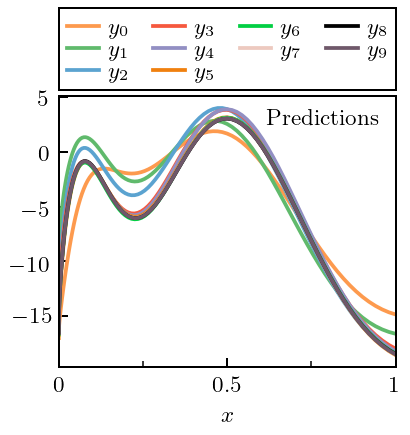

In [16]:
MyGP.PlotCurvesFull()

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


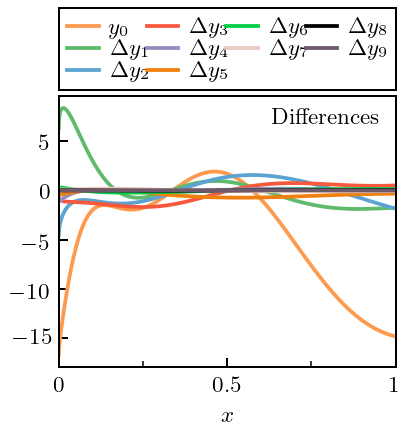

In [17]:
MyGP.PlotCurvesDiffs()

Now show the coefficients $c_n$ (each drawn from one underlying Gaussian Process).
Of course, in a real application, these coefficients would be extracted from the EFT predictions by diving $\Delta y_n$ by $Q^n$.

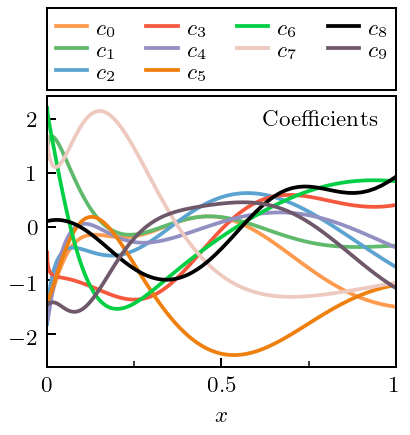

In [18]:
MyGP.PlotCurvesCoeffs()

### Figure 3: Curvewise vs Pointwise Analysis

This next piece of code returns to the curves from Fig. 1(c), and then chooses specific points $x_i$ and computes the standard deviation of the $c_n(x_i)$. It compares that to the standard deviation of the underlying GP.
This "pointwise" approach was employed in Melendez et al. (2017) using a Bayesian formalism. The new GP approach has the advantage of combining data from across the domain (accounting for correlations!) to estimate the variance $\bar c$.

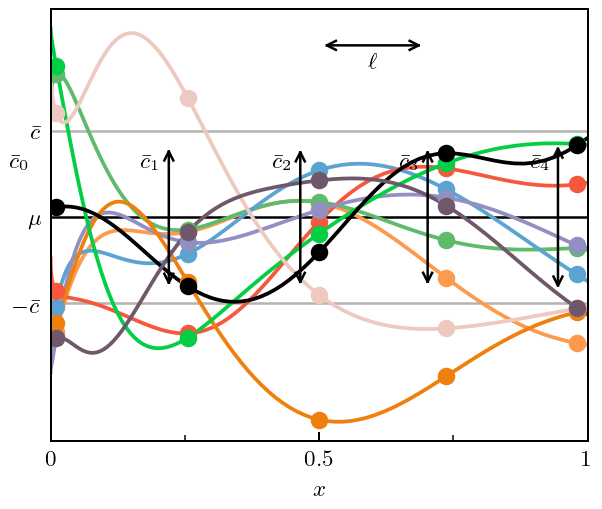

In [19]:
# creates a "mask" of points for comparing expected and true GP curve variance
MyGP.PlotPointwiseVariance(MyGP.x_train_mask)

### Figure 4: Interpolation and Regression with Gaussian Processes

Now we do an example of interpolation, where the training points are exact ($\sigma_n=0$) and regression, where the training points have some errors (we choose $\sigma_n=0.15$).
Training points are shown, with true curves indicated as solid lines, and mean of GP the dashed line. The bands are 95% (2$\sigma$) credible intervals.
For this exercise we choose the underlying curves to be $c_1$ (interpolation) and $c_3$ (regression). 

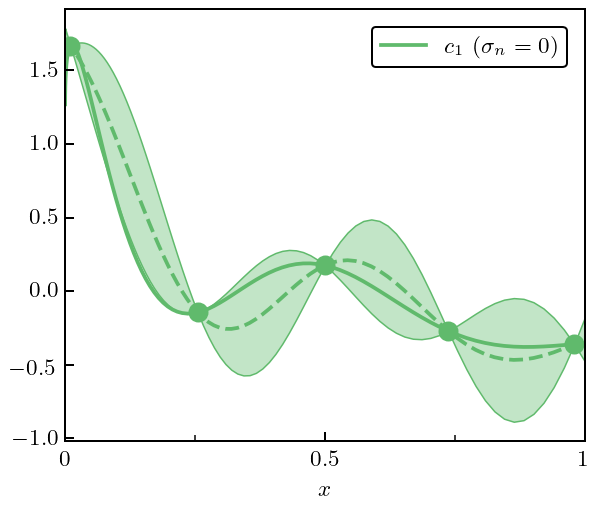

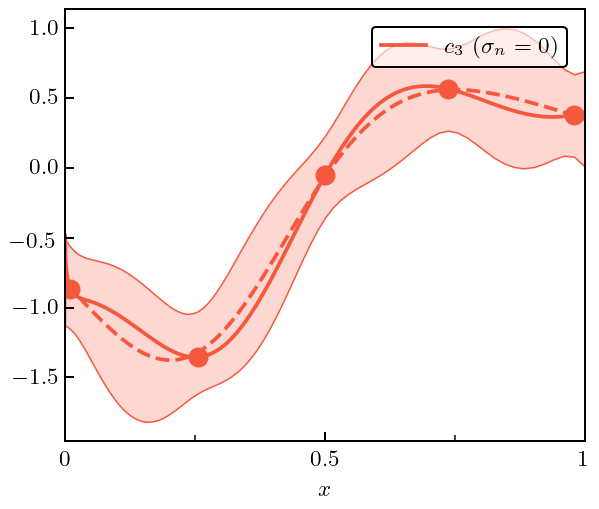

In [20]:
interp_idx = 1  # pick out c_1
MyGP.PlotSingleCurveFit(interp_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd, nugget = 0)

regres_sd = 0.15 # pointwise uncertainty
regres_idx = 3  # pick out c_3
MyGP.PlotSingleCurveFit(regres_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd, \
                        nugget = regres_sd**(2))

### Figure 5: GP Priors

Now we plot the priors on our GP. The prior on $\mu$ is a Gaussian, for a given value of $\bar{c}$. For $\bar{c}$ we take a prior that is an inverse $\chi^2$ distribution. The parameters of the $\chi^2$ are:
1. $\nu_0$, the prior number of degrees of freedom;
2. $\tau_0^2$, the prior scale. If $\nu$ becomes large this becomes the MAP value for $\bar{c}$. 

Note that in the opposite limit, where $\nu_0=0$ the prior becomes the scale invariant "Jeffreys prior".

The joint prior pdf is then
$$\mu,\bar{c}^2 \sim N \chi^{-2}(\eta_0,V_0,\nu_0,\tau_0^2)$$

This is mathematically equivalent to a normal-inverse-gamma prior, a fact which we exploit below.

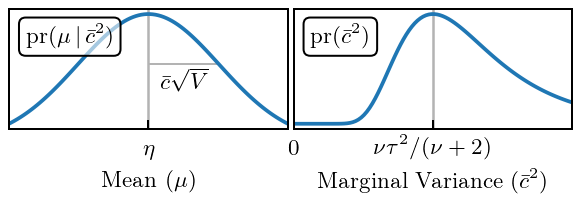

In [21]:
mean = 0
# The uncertainty (std-dev) of mu is Sqrt(V) times cbar,
# the plot is generated for V=1
disp = 1
df = 15
tau2 = (df + 2) / df  # Will put the mode at $\bar c = 1$
gaussian_sd = np.sqrt(tau2*disp)

# Convert to inverse gamma
a = df / 2.
b = df * tau2 / 2.

gaus = stats.norm(mean, gaussian_sd)
igam = stats.invgamma(a, scale=b)
mu_vals = np.linspace(-2.1, 2.1, 100)
cbar_vals = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 2, figsize=(3.4, 1.3))

# Plot curves
ax[0].plot(mu_vals, gaus.pdf(mu_vals))
ax[1].plot(cbar_vals, igam.pdf(cbar_vals))

# Add text boxes
ax[0].text(0.06, 0.87, r'pr($\mu \,|\, \bar c^2$)', ha='left', va='top',
           transform=ax[0].transAxes,
           bbox=text_bbox)
ax[1].text(0.06, 0.87, r'pr($\bar c^2$)', ha='left', va='top',
           transform=ax[1].transAxes,
           bbox=text_bbox
          )

# Format plots
line_color = gray
ax[0].set_xlabel(r'Mean ($\mu$)', labelpad=4.5)
# ax[0].set_xlabel(r'Mean ($\mu$)')
ax[1].set_xlabel(r'Marginal Variance ($\bar c^2$)')
ax[0].set_yticks([])
ax[1].set_yticks([])
# plt.xlabel()

ax[0].axvline([mean], 0, 1, c=line_color, zorder=0, lw=1)
# ax[0].set_xticks([-gaussian_sd, mean, gaussian_sd])
# ax[0].set_xticklabels([r'$-\bar c\sqrt{V}$', r'$\eta$', r'$\bar c\sqrt{V}$'], va='bottom')
ax[0].set_xticks([mean])
ax[0].set_xticklabels([r'$\eta$'], va='bottom')
ax[0].tick_params(pad=12)
ax[0].arrow(0, gaus.pdf(gaussian_sd), gaussian_sd, 0, color=line_color, head_width=0., width=0.0001)
# ax[0].text(gaussian_sd+0.25, gaus.pdf(gaussian_sd), r'$\bar c\sqrt{V}$',
#            verticalalignment='center', horizontalalignment='left')
ax[0].text(gaussian_sd/2, gaus.pdf(gaussian_sd)-.02, r'$\bar c\sqrt{V}$',
           verticalalignment='top', horizontalalignment='center')
ax[1].axvline([df * tau2 / (df+2)], 0, 1, c=line_color, zorder=0, lw=1)
ax[1].set_xticks([0, df * tau2 / (df+2)])
ax[1].set_xticklabels([0, r'$\nu\tau^2/(\nu+2)$'], va='bottom')
ax[1].tick_params(pad=12)

fig.tight_layout(w_pad=0)
# fig.savefig('figures/priors')

### Figure 6: Applications

We now consider three different situations where we can use our formalism to compute truncation errors.
1. Straightforward computation in the situation that computing $y_k(x)$ is "cheap", and we can evaluate it at as many points as we wish.
2. The situation where computing $y_k(x)$ is expensive, and we wish to obtain the uncertainty at some $x$, where $y_k(x)$ was not explicitly computed. In this situation we will use our GPs for interpolation too, and then combine the interpolation and truncation error to assess the overall error of our prediction.
3. Truncation errors in the presence of constraints, i.e., a situation where a symmetry guarantees that $\delta y_k(x_0)=0$ at some particular $x_0$.

#### Figure 6(a): Inexpensive Systems

In the figure we show the "EFT prediction" $y_n(x)$ at each order $n$, together with the associated 95% credible interval. The code to do this is actually just two lines, now that we have set up the input data, the mask, and the GP kernel. 

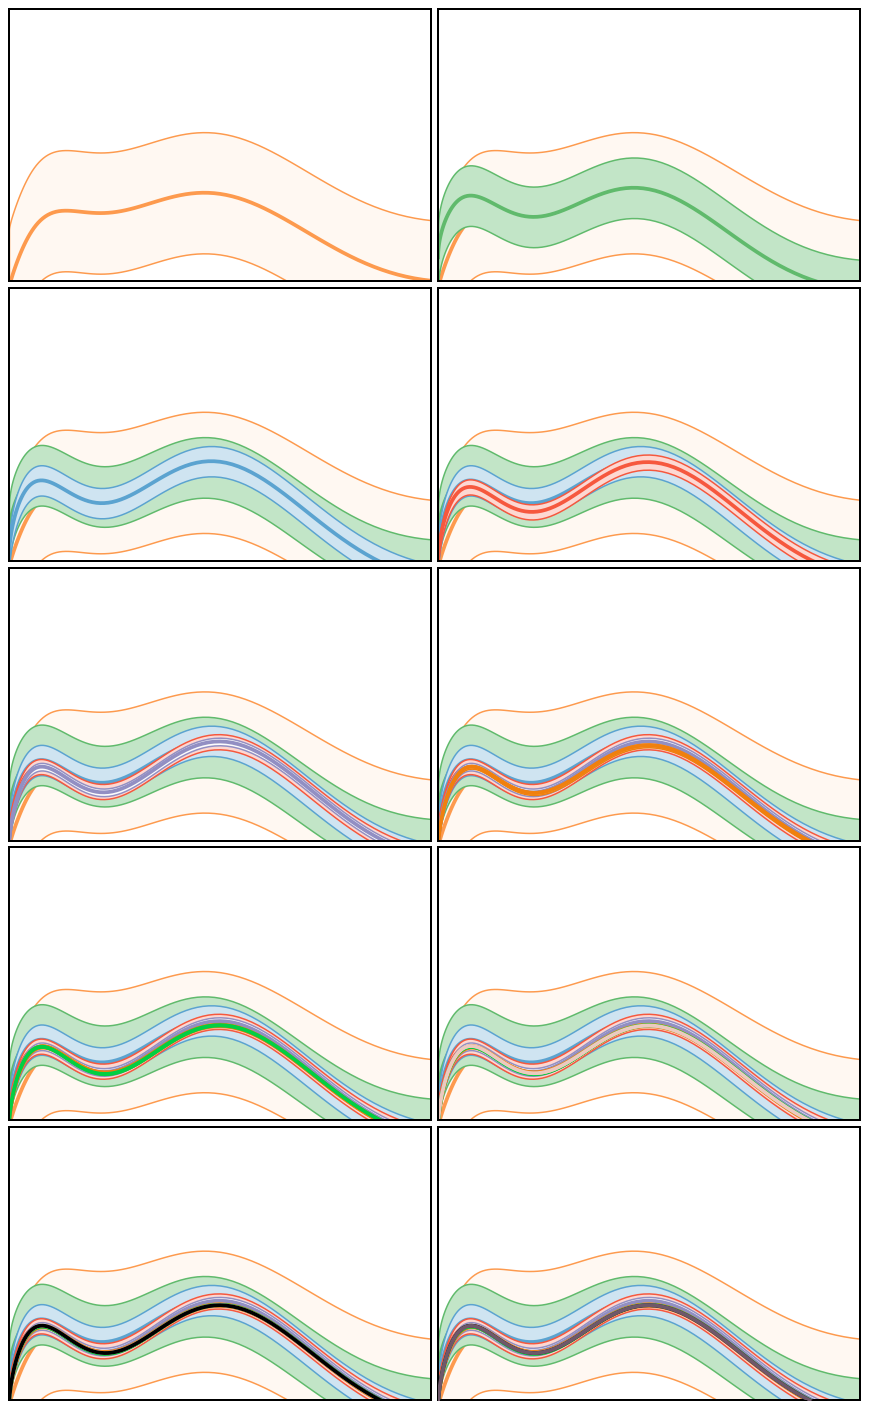

In [22]:
MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = False)

#### Figure 6(b): Expensive Systems

The figures in this case are similar, but now the GP is trained only at the points indicated by the dots.
The total error bands now include both truncation and interpolation error.
Note how the total error on the EFT prediction expands or contracts as one moves away from or towards the points where we have "exact" EFT calculations.

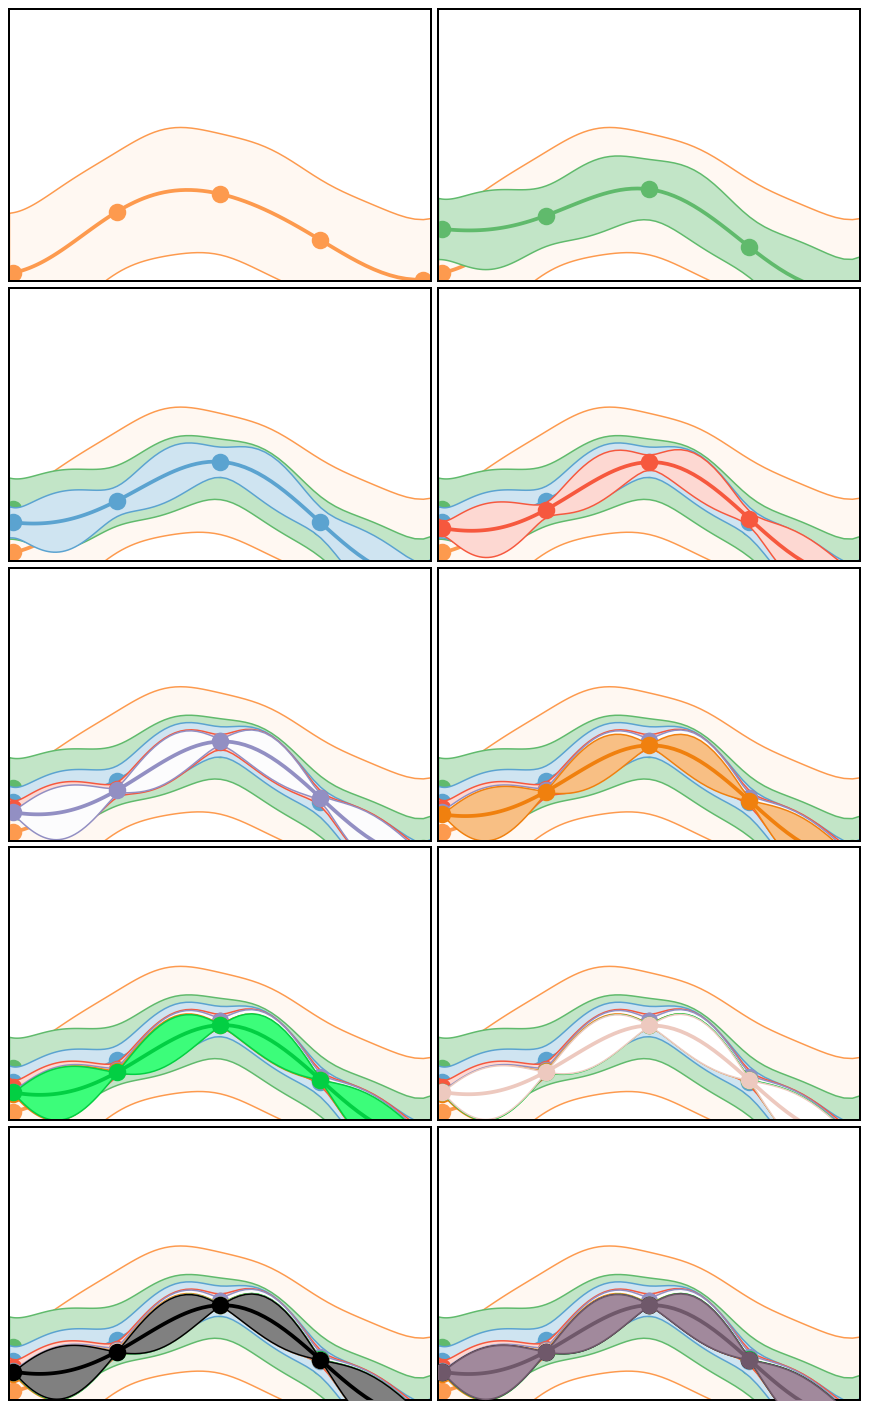

In [23]:
MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = True)

#### Figure 6(c): Constraints

We now consider the case that the observable in question is constrained to be zero at both x=0 and x=1. This means that the EFT should maintain that constraint at all orders, and that the truncation-error model should incorporate that constraint. The truncation classes in `gsum` have two parameters in their `.fit` methods that permit the inclusion of constraints: `dX` and `dy`. Using that feature, things proceed in parallel to Fig. 6(a).

In [24]:
# This generates data that are constrained as described above
ConstrainedHyper = GPHyperparameters(ls = 0.25, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = 1e-7, seed = seed)

# different grid of x-values for the constrained GP
x2 = np.linspace(0, 1, 50)

MyGPConstrained = GSUMobj(ConstrainedHyper, OrdersBig, x2, constrained = True)

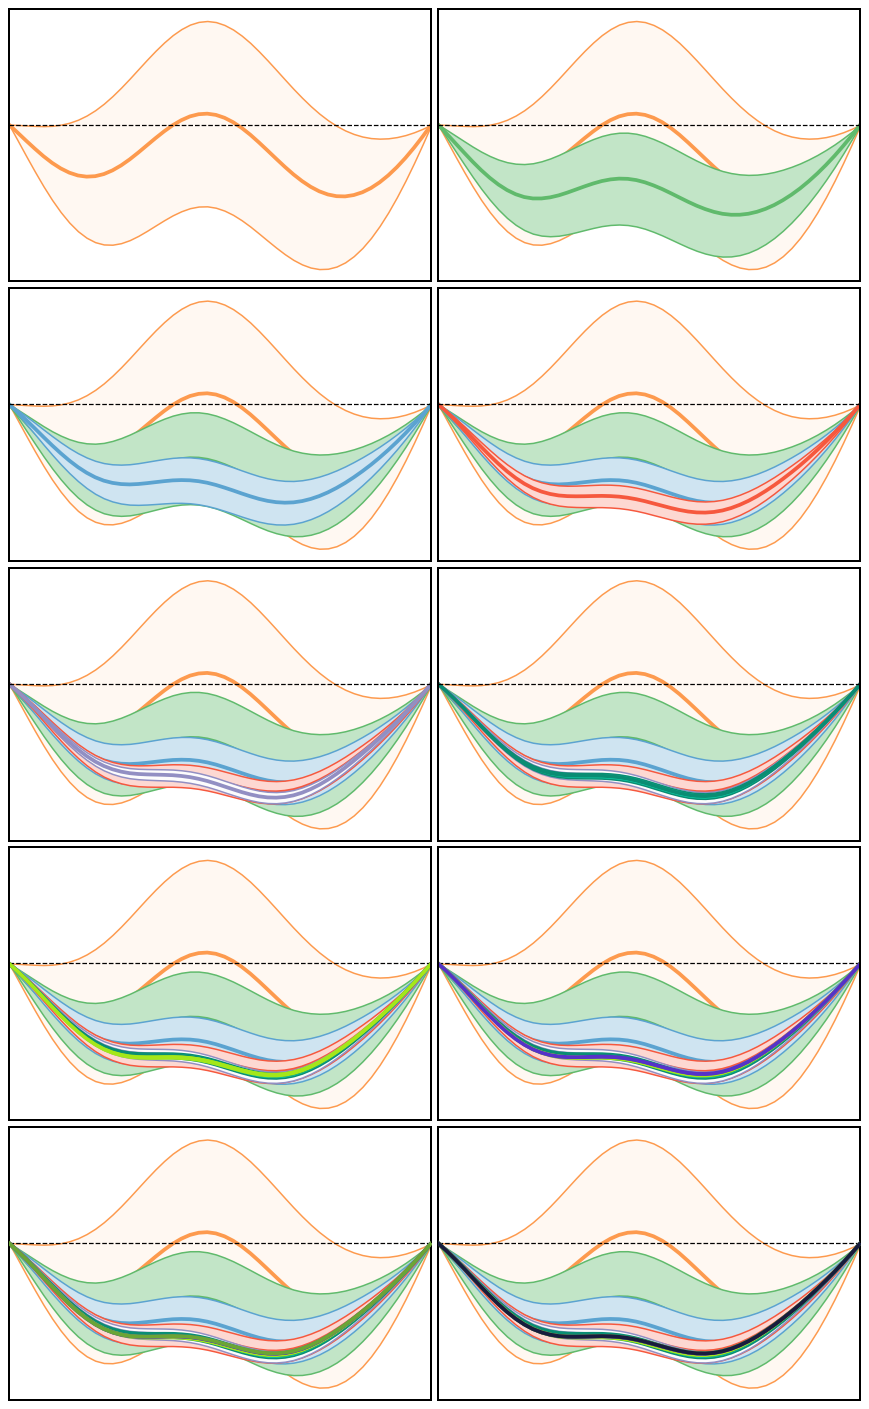

In [25]:
MyGPConstrained.PlotCurvesConstrained(constrained = True)

## Section III: Diagnostics

### Figure 7

#### Figure 7(a)


Here we split the data into a "training set" and a "testing set". The training set is indicated by the dots, and gives the data to which the GP used to assess the truncation error is fit. The location of the testing point is indicated by the tick marks on the x-axis. The solid line indicates the mean value of the GP for each EFT coefficient and the bubbles at the 95% DoB interval.

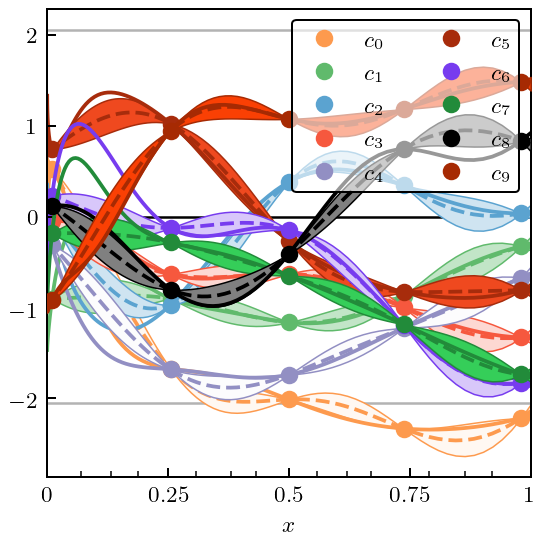

In [26]:
# creates the same GSUM object as before, but with different hyperparameters
JordanHyper = GPHyperparameters(ls = ls, sd = sd, center = 0, ref = ref, ratio = ratio, disp = 0, \
                                nugget = nugget, seed = seed, df = 1, scale = 1)
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power)
MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
                   seed_array)
MyGP.PlotGPCurvesFit()

Here are the best guesses for $\bar c$ and $\ell$ after performing the fit

In [27]:
print(r'Std. dev. expected value:', MyGP.underlying_std)

Std. dev. expected value: 1.0290199652004006


In [28]:
np.sqrt(MyGP.gp_diagnostic.df_ * MyGP.gp_diagnostic.scale_**2 / (MyGP.gp_diagnostic.df_ + 2))

0.9894273391407117

In [29]:
# Print out the kernel of the fitted GP
MyGP.gp_diagnostic.kernel_

RBF(length_scale=0.267) + WhiteKernel(noise_level=1e-10)

#### Figure 7(b): Squared Mahalanobis distance

This is like a $\chi^2$ in the presence of correlations.
The correlations are assessed using the covariance matrix of the fitted GP.
Both the box-and-whisker and histogram versions are plotted.

In [30]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'box')

Adjusted orders: [37  8 12 37 42]
Adjusted ratios: [0.54779819 0.39292764 0.39774294 0.5407721  0.47580836]
Adjusted correlation lengths: [0.19231824 0.22920792 0.12075843 0.28296361 0.18251026]
Adjusted variances: [1.09810885 0.92858234 1.35859485 0.92039713 0.88475341]
Adjusted seeds: [ 981456 1582869 1467034  629246  663086]
The Mahalanobis distance could not be calculated at one or more orders.


In [31]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'hist')

Adjusted orders: [37  8 12 37 42]
Adjusted ratios: [0.54779819 0.39292764 0.39774294 0.5407721  0.47580836]
Adjusted correlation lengths: [0.19231824 0.22920792 0.12075843 0.28296361 0.18251026]
Adjusted variances: [1.09810885 0.92858234 1.35859485 0.92039713 0.88475341]
Adjusted seeds: [ 981456 1582869 1467034  629246  663086]
The Mahalanobis distance could not be calculated at one or more orders.


#### Figure 7(c): Pivoted Cholesky errors
Now we decompose the Mahalanobis distance into its component pieces, by doing a Pivoted Cholesky decomposition on the covariance matrix. The resulting PC errors are then plotted against index. The index can be related to the testing point in question, see Bastos & O'Hagan's seminal article. Note that gsum has the ability to display Pivoted Cholesky (and several other) decompositions of the MD, see third line of code below. 

In [32]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotPC()

Adjusted orders: [37  8 12 37 42]
Adjusted ratios: [0.54779819 0.39292764 0.39774294 0.5407721  0.47580836]
Adjusted correlation lengths: [0.19231824 0.22920792 0.12075843 0.28296361 0.18251026]
Adjusted variances: [1.09810885 0.92858234 1.35859485 0.92039713 0.88475341]
Adjusted seeds: [ 981456 1582869 1467034  629246  663086]
The pivoted Cholesky decomposition could not be calculated at one or more orders.


### Figure 8

Now we compare the truncation errors computed at each order using the GP obtained above with the "true" (summed to order $n=20$) result from the toy EFT (dashed line), see Fig. 8(a). This comparison is done at the validation points indicated by the tick marks on the x-axis and produces the "Credible Interval Diagnostic" plot of Fig. 8(b). Note that `gsum` also has a command to generate this plot.

In [33]:
MyGP.PlotTruncations()

The truncation error curves could not be calculated at one or more orders.


In [34]:
MyGP.PlotCredibleIntervals()

The credible intervals could not be calculated at one or more orders.


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


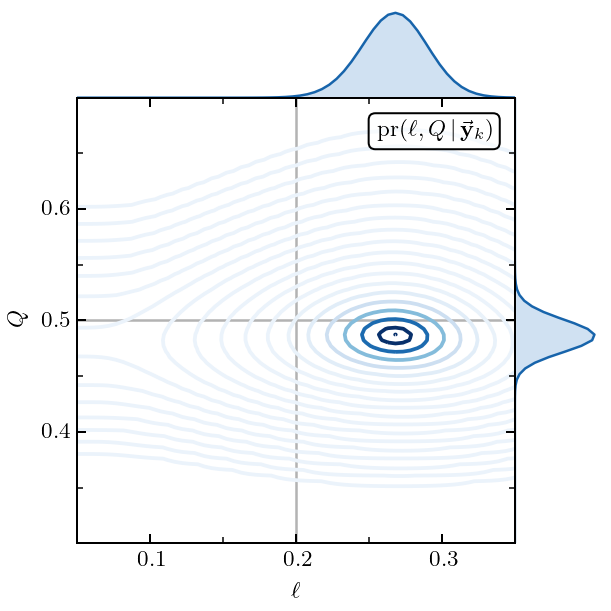

Best Q: 0.48734177215189867
Best length scale: 0.2681414141414141


In [35]:
# posterior grid
JordanPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)
MyGP.PlotPosteriorPDF(JordanPosteriorBounds)
ratio_map_idx, ls_map_idx = np.unravel_index(np.argmax(MyGP.ls_ratio_like), MyGP.ls_ratio_like.shape)
print('Best Q:', MyGP.ratio_vals[ratio_map_idx])
print('Best length scale:', MyGP.ls_vals[ls_map_idx])

| CETERIS PARIBUS | Mahalanobis distance | Pivoted Cholesky decomposition | Credible interval | $Q$-$\ell$ posterior|
| --- | --- | --- | --- | --- |
| Lower one order's correlation length | That order rises a lot | That order is out of bounds for higher index; other orders too, but less so | X | X |
| Raise one order's correlation length | That order falls a lot | Funnel-shaped overall distribution, but with that order hewing closely to the mean | X | X |
| Lower one order's variance | That order falls a little | That order hews closely to the mean | X | X |
| Raise one order's variance | That order rises a little | That order goes out of bounds | X | X |
| $x \rightarrow x^{n}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | Higher $n$ $\rightarrow$ higher predicted correlation length |
| $x \rightarrow x^{\frac{1}{n}}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | X |

## Let's try widgets!

In [36]:
x = np.linspace(0, 1, 100) # grid for x-values

n_orders = 10    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 50  # We are going to treat some high order result as the final, converged answer

# creates the orders_info object
OrdersWidget = order_info(n_orders, final_order)
orders_widget = OrdersWidget.orders_array
orders_all_widget = OrdersWidget.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = None
WidgetHyper = GPHyperparameters(ls = ls, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = nugget, seed = seed)

# posterior grid for the widget
WidgetPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)

In [37]:
# we will alter the hyperparameters of the second order alone
change_order_array = [3]
change_ratio_array = [ratio]
# seed_array = np.random.randint(0, 2000000, 1)
seed_array = [None]
# sets a seed for the random color-chooser for stability across parameters and diagnostic widgets
# good ones: 62, 75, 81, 82, 90
color_seed_widget = 81

In [38]:
def plot_MD_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   plot_type, color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the Mahalanobis distance.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotMD(plot_type = plot_type)
    except:
        print("The Mahalanobis distance could not be calculated at one or more orders.")

def plot_PC_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the pivoted Cholesky decomposition.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPC()
    except:
        print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")

def plot_weather_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the pivoted Cholesky decomposition.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotCredibleIntervals()
    except:
        print("The credible intervals could not be calculated at one or more orders.")

def plot_posterior_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                       slider_power_value, change_order_array, change_ratio_array, seed_array, \
                       widgetposteriorbounds, color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the pivoted Cholesky decomposition.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
    except:
        print("The posterior probability distribution could not be calculated.")

def plot_diagnostics_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   widgetposteriorbounds, plot_type = 'box', color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the Mahalanobis distance, the pivoted 
    Cholesky decomposition, the credible intervals, and the posterior PDF. Also suppresses warnings.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    # we don't need to bother with warnings when we run this snippet of code
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            WidgetGP.PlotMD(plot_type = plot_type)
        except:
            print("The Mahalanobis distance could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPC()
        except:
            print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotCredibleIntervals()
        except:
            print("The credible intervals could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
        except:
            print("The posterior probability distribution could not be calculated.")

In [39]:
# initializes a slider for the correlation length in terms of the default value
slider_ls = widgets.FloatSlider(
    min = ls * 3/4,
    max = ls * 5/3,
    step = 0.01,
    description = 'Length scale:',
    value = ls, 
    continuous_update = False
)

# initializes a slider for the variance in terms of the default value
slider_sd = widgets.FloatSlider(
    min = sd * 0.3,
    max = sd / 0.3,
    step = 0.01,
    description = 'Variance:',
    value = sd, 
    continuous_update = False
)

# initializes a slider for the polynomial power of x in terms of the default value
slider_power = widgets.RadioButtons(
    options = [0.250, 0.333, 0.500, 1.000, 2.000, 3.000, 4.000],
    value = 1., 
    description = 'x-power:',
    disabled = False, 
    continuous_update = False
)

In [40]:
# using the slider interactively, plots the Mahalanobis distance
interactive_plot_md = widgets.interactive(plot_MD_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          plot_type = widgets.fixed('box'), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_md.children[-1]
interactive_plot_md

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

In [41]:
# using the slider interactively, plots the pivoted Cholesky decomposition
interactive_plot_pc = widgets.interactive(plot_PC_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_pc.children[-1]
interactive_plot_pc

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

In [42]:
interactive_plot_weather = widgets.interactive(plot_weather_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_weather.children[-1]
interactive_plot_weather

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

In [43]:
interactive_plot_posterior = widgets.interactive(plot_posterior_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(JordanHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_posterior.children[-1]
interactive_plot_posterior

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

In [44]:
# plotting all the diagnostics without interative_output
interactive_plot_all = widgets.interactive(plot_diagnostics_widget, {'manual': True}, \
                                      slider_ls_value = slider_ls, \
                                      slider_sd_value = slider_sd, \
                                      slider_power_value = slider_power, \
                                      widgethyper = widgets.fixed(JordanHyper), \
                                      orderswidget = widgets.fixed(OrdersWidget), \
                                      x = widgets.fixed(x), \
                                      change_order_array = widgets.fixed(change_order_array), \
                                      change_ratio_array = widgets.fixed(change_ratio_array), \
                                      seed_array = widgets.fixed(seed_array), \
                                      widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                      color_seed = widgets.fixed(color_seed_widget), \
                                      plot_type = widgets.fixed('box'))
output = interactive_plot_all.children[-1]
interactive_plot_all

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

In [45]:
# Set up the interactive_output widget 
plot_out = widgets.interactive_output(plot_diagnostics_widget, \
                        dict(
                        widgethyper = widgets.fixed(WidgetHyper), \
                        orderswidget = widgets.fixed(OrdersWidget), \
                        x = widgets.fixed(x), \
                        slider_ls_value = slider_ls, \
                        slider_sd_value = slider_sd, \
                        slider_power_value = slider_power, \
                        change_order_array = widgets.fixed(change_order_array), \
                        change_ratio_array = widgets.fixed(change_ratio_array), \
                        seed_array = widgets.fixed(seed_array), \
                        widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                        plot_type = widgets.fixed('box'), \
                        color_seed = widgets.fixed(color_seed_widget))
                        )
plot_out.observe(True, names = 'manual')
# plot_out = widgets.interactive_output(plot_diagnostics_widget, \
#                         {'manual': True, \
#                         'widgethyper': widgets.fixed(WidgetHyper), \
#                         'orderswidget': widgets.fixed(OrdersWidget), \
#                         'x': widgets.fixed(x), \
#                         'slider_ls_value': slider_ls, \
#                         'slider_sd_value': slider_sd, \
#                         'slider_power_value': slider_power, \
#                         'change_order_array': widgets.fixed(change_order_array), \
#                         'change_ratio_array': widgets.fixed(change_ratio_array), \
#                         'seed_array': widgets.fixed(seed_array), \
#                         'widgetposteriorbounds': widgets.fixed(WidgetPosteriorBounds), \
#                         'plot_type': widgets.fixed('box'), \
#                         'color_seed': widgets.fixed(color_seed_widget)}
#                         )

# Now do some manual layout, where we can put the plot anywhere using plot_out
# hbox1 = widgets.HBox([interactive_plot_md, interactive_plot_pc, interactive_plot_weather, \
#               interactive_plot_posterior])
vbox1 = widgets.VBox([slider_ls, slider_sd])
hbox1 = widgets.HBox([vbox1, slider_power])
# hbox2 = widgets.HBox([interactive_plot_pc])
# hbox3 = widgets.HBox([interactive_plot_weather])
# hbox4 = widgets.HBox([interactive_plot_posterior])

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list?) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = widgets.VBox([hbox1], layout=widgets.Layout(min_height=tab_height))
tab = widgets.Tab(children=[tab0])
tab.set_title(0, 'GP Parameters')

# Release the Kraken!
vbox1 = widgets.VBox([tab, plot_out])
display(vbox1)

### Figure 10: Misestimated $Q$

Now we turn our attention to what failure looks like. In this particular case we deliberately misestimate the expansion parameter. This should cause the coefficients to systematically grow with order (if $Q$ is too small) or decrease with order (if $Q$ is too big). In either case the GPs representing coefficients at different orders will not have a common variance. We hope to be able to see that in our diagnostics.

In [46]:
# Here we extract c_n from predictions y_n assuming Q=0.3, instead of the true Q=0.5
coeffs_wrong = gm.coefficients(data, ratio=0.3, ref=ref, orders=orders)

# Fit the GP to those coefficients
gp_diagnostic_wrong = gm.ConjugateGaussianProcess(
    kernel=kernel_fit, center=center0, disp=disp0, df=df0, scale=scale0)
gp_diagnostic_wrong.fit(X[x_train_mask], coeffs_wrong[x_train_mask])
pred, std = gp_diagnostic_wrong.predict(X, return_std=True)
underlying_std = np.sqrt(gp_diagnostic_wrong.cov_factor_)

# Now plot the results
fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(orders):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, coeffs_wrong[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[x_train_mask], coeffs_wrong[x_train_mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(x[x_valid_mask], minor=True)
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.legend(ncol=2)
fig.tight_layout();
# fig.savefig('figures/toy_interp_and_underlying_processes_small_Q')

NameError: name 'data' is not defined

Note that the fit to the coefficients does not look too bad by eye, although one might complain about the 95% DoB intervals covering the actual value too much of the time. 

We now print out the kernel and compute the mean and covariance matrix. 

In [ ]:
gp_diagnostic_wrong.kernel_

In [ ]:
mean_wrong = gp_diagnostic_wrong.mean(X[x_valid_mask])
cov_wrong = gp_diagnostic_wrong.cov(X[x_valid_mask])
pred_wrong = gp_diagnostic_wrong.predict(X[x_valid_mask])
gr_dgn_wrong = gm.GraphicalDiagnostic(pred_wrong, mean=mean_wrong, cov=cov_wrong, colors=colors, gray=gray, black=softblack)

The last line here generates all the desired graphical diagnostics for this GP analysis (which should not look good).
Now we specifically print out the Mahalanobis distance squared of each GP and the PC errors.

In [ ]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_wrong.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 25)
ax.set_yticks([0, 5, 10, 15, 20, 25])
fig.tight_layout();
# fig.savefig('figures/toy_md_small_Q')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_wrong.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.04, 0.96, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
#     fig.savefig('figures/toy_pc_vs_index_small_Q')

The $c_4$ coefficient is too large and has biased the estimation of $\bar c$ upwards. Thus, the MD is too small for most of the curves.
By looking at the PC decomposition, we see that there is a problem with the length scale estimation because the values become small at large index. Indeed, by inspecting the kernel, we see that the estimate of $\ell$ is too small (0.175, when the true value is 0.2).

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [ ]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction='np', single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q

In [ ]:
# We get the NN data from a separate place in our github respository.
nn_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-0p9fm.h5?raw=true'

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = h5file.get_node('/SGT').read()
DSG = h5file.get_node('/DSG').read()
AY = h5file.get_node('/PB').read()
A = h5file.get_node('/A').read()
D = h5file.get_node('/D').read()
AXX = h5file.get_node('/AXX').read()
AYY = h5file.get_node('/AYY').read()
q_cm = h5file.get_node('/q_cm').read()
t_lab = h5file.get_node('/t_lab').read()
degrees = h5file.get_node('/degrees').read()

q_cm *= hbarc

nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

In [ ]:
nn_orders = np.array([0, 2, 3, 4, 5])
# This ensures we only analyze the non-trivial information at
# O(Q^2), O(Q^3), O(Q^4), and O(Q^5)
excluded = [0]
nn_orders_mask = ~ np.isin(nn_orders, excluded)
Deg = degrees[:, None]
Lambdab = 600

### Figure 11: Differential Cross Section


In [ ]:
# Define the kinematics of the dcs we are analyzing
t_lab_dsg = 150
t_lab_idx_dsg = np.nonzero(t_lab_dsg == t_lab)[0][0]
q_cm_dsg = q_cm[t_lab_idx_dsg]

deg_train_mask_dsg, deg_valid_mask_dsg = regular_train_test_split(degrees, dx_train=30, dx_test=10)
ratio_dsg = Q_approx(t_lab_dsg, Lambda_b=Lambdab)

dsg_train = DSG.T[deg_train_mask_dsg, t_lab_idx_dsg]
dsg_valid = DSG.T[deg_valid_mask_dsg, t_lab_idx_dsg]
dsg_vs_theta = DSG.T[:, t_lab_idx_dsg]
dsg_ref = dsg_vs_theta[:, -1]

print(dsg_vs_theta.shape)
print(ratio_dsg.shape)
print(dsg_ref.shape)
print(nn_orders.shape)

# Compute the coefficients and define the kernel
coeffs_dsg = gm.coefficients(dsg_vs_theta, ratio=ratio_dsg, ref=dsg_ref, orders=nn_orders)[:, nn_orders_mask]
kernel_dsg = RBF(length_scale=40, length_scale_bounds=(20, 60)) + WhiteKernel(1e-10, noise_level_bounds='fixed')

gp_dsg = gm.ConjugateGaussianProcess(
    kernel_dsg, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10)

In [ ]:
gp_dsg.fit(Deg[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg])
pred, std = gp_dsg.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_dsg.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(degrees, coeffs_dsg[:, i], c=colors[i], zorder=i-5)
    ax.plot(degrees[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(degrees, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(degrees[deg_valid_mask_dsg], minor=True)
ax.set_xticks([30, 60, 90, 120, 150])
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xlabel(r'$\theta$ (deg)')
ax.legend(ncol=2, borderpad=0.4,# labelspacing=0.5, columnspacing=1.3,
          borderaxespad=0.6,
          title=r'$\sigma(\theta, E_{\mathrm{lab}}=150\,\mathrm{MeV})$')
fig.tight_layout();
# fig.savefig('figures/dsg_interp_and_underlying_processes')

And then things follow as before: print out the kernel, define the mean and covariance, do the diagnostics, and plot Mahalanobis distance and Pivoted Cholesky errors.

In [ ]:
gp_dsg.kernel_

In [ ]:
mean_dsg = gp_dsg.mean(Deg[deg_valid_mask_dsg])
cov_dsg = gp_dsg.cov(Deg[deg_valid_mask_dsg])
gr_dgn_dsg = gm.GraphicalDiagnostic(coeffs_dsg[deg_valid_mask_dsg], mean_dsg, cov_dsg, colors=colors,
                                    gray=gray, black=softblack)

In [ ]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_dsg.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 90)
fig.tight_layout();
# fig.savefig('figures/dsg_md')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_dsg.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    ax.set_ylim(-6, 6)
    fig.tight_layout();
    plt.show()
#     fig.savefig('figures/dsg_pc_vs_index')

In this case the $\mathcal{O}(Q^4)$ and $\mathcal{O}(Q^5)$ coefficients both have MDs that are too large. But now this can be traced to PC errors at too large an index, which is typically an indication of an incorrect correlation structure in the Gaussian Process. 

### Figure 12: Total Cross Section

In [ ]:
# Split into training and testing data
tlab_train_mask_sgt, tlab_valid_mask_sgt = regular_train_test_split(t_lab, dx_train=100, dx_test=25, xmin=100)

# Define Q at each t_lab
ratio_sgt = Q_approx(t_lab, Lambda_b=Lambdab)

Tlab = t_lab[:, None]

sgt_train = SGT.T[tlab_train_mask_sgt]
sgt_valid = SGT.T[tlab_valid_mask_sgt]
sgt_ref = SGT[0]
print(sgt_ref.shape)

# Extract the coefficients and define kernel
coeffs_sgt = gm.coefficients(SGT.T, ratio=ratio_sgt, ref=sgt_ref, orders=nn_orders)[:, nn_orders_mask]
kernel_sgt = RBF(length_scale=100, length_scale_bounds=(60, 150)) + WhiteKernel(1e-10, noise_level_bounds='fixed')

# Define the GP
gp_sgt = gm.ConjugateGaussianProcess(
    kernel_sgt, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10, random_state=4)

In [ ]:
gp_sgt.fit(Tlab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt])
pred, std = gp_sgt.predict(Tlab, return_std=True)
underlying_std = np.sqrt(gp_sgt.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(t_lab, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(t_lab, coeffs_sgt[:, i], c=colors[i], zorder=i-5)
    ax.plot(t_lab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(t_lab, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(t_lab[tlab_valid_mask_sgt], minor=True)
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xticks([0, 100, 200, 300])
ax.set_xlabel(r'$E_{\mathrm{lab}}$ (MeV)')
ax.legend(ncol=2, title=r'$\sigma_{\mathrm{tot}}(E_{\mathrm{lab}})$')
fig.tight_layout();
# fig.savefig('figures/sgt_interp_and_underlying_processes_large_tlab')

Already from the plot it is clear that $c_5$ is problematic, although that problem occurs only at low energy. This will show up as a large MD and, once again, PC errors at high index that are too large.

In [ ]:
gp_sgt.kernel_

In [ ]:
mean_sgt = gp_sgt.mean(Tlab[tlab_valid_mask_sgt])
cov_sgt = gp_sgt.cov(Tlab[tlab_valid_mask_sgt])
gr_dgn_sgt = gm.GraphicalDiagnostic(coeffs_sgt[tlab_valid_mask_sgt], mean_sgt, cov_sgt, colors=colors, gray=gray,
                                   black=softblack)

In [ ]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_sgt.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 50)
fig.tight_layout();
# fig.savefig('figures/sgt_md_large_tlab')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_sgt.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6], minor=True)
    ax.set_xticks([1, 3, 5, 7])
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
#     fig.savefig('figures/sgt_pc_vs_index_large_tlab')

### Figure 13: Spin Observable $A$

Finally, we look at an observable that has a symmetry constraint. The spin observable $A$, for which we choose the energy $T_{\rm lab}=96$ MeV. $A(\theta=0)=0$ (in the absence of magnetic-moment interactions). 

In [ ]:
t_lab_A = 96
t_lab_idx_A = np.nonzero(t_lab_A == t_lab)[0][0]
q_cm_A = q_cm[t_lab_idx_A]

degrees_train_mask_A, degrees_valid_mask_A = regular_train_test_split(degrees, dx_train=40, dx_test=10)

ratio_A = Q_approx(t_lab_A, Lambda_b=Lambdab)

A_train = A.T[degrees_train_mask_A, t_lab_idx_A]
A_valid = A.T[degrees_valid_mask_A, t_lab_idx_A]
A_vs_theta = A.T[:, t_lab_idx_A]

coeffs_A = gm.coefficients(A_vs_theta, ratio=ratio_A, orders=nn_orders)

kernel_A = RBF(length_scale=30) + WhiteKernel(nugget, noise_level_bounds='fixed')

In [ ]:
gp_coeffs_A = gm.ConjugateGaussianProcess(kernel=kernel_A, center=center0, disp=disp0, df=df0, scale=scale0)
gp_coeffs_A.fit(Deg[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, 1:])

pred, std = gp_coeffs_A.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_coeffs_A.cov_factor_)

# Compute the std-dev under the symmetry constraint
dX_A = np.array([[0]])
std_interp = np.sqrt(np.diag(
    gp_coeffs_A.cov(Deg) -
    gp_coeffs_A.cov(Deg, dX_A) @ np.linalg.solve(gp_coeffs_A.cov(dX_A, dX_A), gp_coeffs_A.cov(dX_A, Deg))
))

fig, ax = plt.subplots(figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, coeffs_A[:, i+1], c=colors[i], zorder=i-5)
    ax.plot(degrees[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, i+1], c=colors[i],
            zorder=i-5, ls='', marker='o', label=r'$c_{n}$'.format(n=n))


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.plot(degrees, 2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.plot(degrees, -2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.tick_params(which='minor', bottom=False, top=True)
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_xticks([0, 40, 80, 120, 160])
ax.set_ylim(-5, 5)
leg = ax.legend(ncol=2, borderpad=0.4, columnspacing=0.8, borderaxespad=0.6)
# leg.legendPatch.set_facecolor('none')
ax.text(0.055, 0.965, r'$A(\theta)$', transform=ax.transAxes, va='top',
        bbox=dict(boxstyle="round", ec=softblack, fc='white', lw=0.8))
fig.tight_layout();
# fig.savefig('figures/spin_obs_A_coefficients')

First we proceed as if we did not know that there was a symmetry at $\theta=0$.

In [ ]:
gp_A = gm.TruncationGP(kernel_A, ref=1, ratio=ratio_A, center=center0, disp=disp0, df=df0, scale=scale0, excluded=excluded)

In [ ]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders)

fig, axes = plt.subplots(math.ceil(n_orders / 2), 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, n_orders):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
# fig.savefig('figures/spin_obs_A_full_pred_unconstrained')

And now we incorporate the constraint. We do not plot the revised coefficients, but only show the resulting EFT predictions, with truncation errors. The truncation errors now respect the symmetry constraint, because the GP does. 

In [ ]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders, dX=np.array([[0]]), dy=[0])

fig, axes = plt.subplots(math.ceil(n_orders / 2), 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, n_orders):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
# fig.savefig('figures/spin_obs_A_full_pred_constrained')

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def mask_mapper(array_from, array_to, mask_from):
    # mask = [( np.where(xx_shifted == find_nearest(xx_shifted, i), xx_shifted) ) for i in xx[x_train_mask]]
    mask_array = [( np.argwhere(array_to == find_nearest(array_to, i)) ) for i in array_from[mask_from]]
    # print(mask_array[4])
    mask = np.zeros(len(array_from))
    for i in range(len(mask_array)):
        mask[mask_array[i]] = 1
    # print(mask)
    return mask

In [ ]:
xx = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
xx_shifted = xx**(2)
print(xx_shifted)

In [ ]:
# creates the masks for training and testing the GPs
x_train_mask, x_valid_mask = regular_train_test_split(xx, \
                    dx_train = 2, dx_test = 1, offset_train = 1, offset_test = 1)
print(x_train_mask)
print(xx[x_train_mask])
print(x_valid_mask)

In [ ]:
# # mask = [( np.where(xx_shifted == find_nearest(xx_shifted, i), xx_shifted) ) for i in xx[x_train_mask]]
# mask_array = [( np.argwhere(xx_shifted == find_nearest(xx_shifted, i)) ) for i in xx[x_train_mask]]
# # print(mask_array[4])
# mask = np.zeros(len(xx))
# for i in range(len(mask_array)):
#     mask[mask_array[i]] = 1
# # print(mask)
print(mask_mapper(xx, xx_shifted, x_train_mask))

In [ ]:
np.array(np.array([1, 0, 1]), dtype = bool)

In [ ]:
positions = np.array([[2, 5], [6, 7], [4, 1]])
print(max(positions[:, 1]))
print(10 * max(positions[:, 1]))
print(np.log10(10 * max(positions[:, 1])))
print(np.ceil(np.log10(10 * max(positions[:, 1]))))
print( 10**(np.ceil(np.log10(10 * max(positions[:, 1])))) )

In [ ]:
np.ceil(67 / 20) * 20